In [ ]:
from matplotlib import pyplot as plt
import cv2, numpy as np, pathlib, os, PIL, PIL.Image, glob
import numpy as np
from skimage import data
from skimage import io, morphology
import tensorflow as tf
import time
from PIL import Image
import math
import timeit
import pywt
from sklearn.metrics import accuracy_score as acc, auc, f1_score
import warnings
from sklearn import metrics

width = 512
height = 512
dim = (width, height)
sharpen = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))


: /physical_device:CPU:0
: /physical_device:GPU:0


In [ ]:
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

DEVICES AVAILABLE: 1


In [ ]:
def encode(labels):

    from sklearn.preprocessing import OneHotEncoder
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = labels.reshape(len(labels), 1)           #before labels_batch
    label_encoded = onehot_encoder.fit_transform(integer_encoded)
    return label_encoded


In [ ]:
import tensorflow as tf

# with strategy.scope():

def get_model(width, height):

    inputs = tf.keras.Input((width, height, 1))
    conv1 = tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1)(inputs)
    BN1 = tf.keras.layers.BatchNormalization()(conv1)
    relu1 = tf.keras.layers.Activation(activation='relu')(BN1)

    conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2,padding='same')(relu1)
    BN2 = tf.keras.layers.BatchNormalization()(conv2)
    relu2 = tf.keras.layers.Activation(activation='relu')(BN2)

    conv3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,padding='same')(relu2)
    BN3 = tf.keras.layers.BatchNormalization()(conv3)
    relu3 = tf.keras.layers.Activation(activation='relu')(BN3)

    skipconv = tf.keras.layers.Conv2D(filters=32, kernel_size=1, strides=2)(relu1)

    Add = tf.keras.layers.Add()([skipconv,relu3])
    AvgPool = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=2)(Add)
    FC = tf.keras.layers.Flatten()(AvgPool)

    output = tf.keras.layers.Dense(2,activation='softmax')(FC)



    model = tf.keras.Model(inputs, output,name='BASE_MODEL')

    return model





In [ ]:


# This function does the coefficient fusing according to the fusion method
def fuseCoeff(cooef1, cooef2, method):

    if (method == 'mean'):
        cooef = (cooef1 + cooef2 ) / 3
    # elif (method == 'min'):
    #     cooef = np.minimum(cooef1,cooef2,cooef3)
    # elif (method == 'max'):
    #     cooef = np.maximum(cooef1,cooef2,cooef3)
    # else:
    #     cooef = []

    return cooef


def FUSION(I1,I2):

    # Params
    FUSION_METHOD = 'mean' # Can be 'min' || 'max || anything you choose according theory

    # We need to have both images the same size
    # I2 = cv2.resize(I2,I1.shape) # I do this just because i used two random images

    ## Fusion algo

    # First: Do wavelet transform on each image
    wavelet = 'db1'
    cooef1 = pywt.wavedec2(I1[:,:], wavelet)
    cooef2 = pywt.wavedec2(I2[:,:], wavelet)
    # cooef3 = pywt.wavedec2(I3[:,:], wavelet)

    # Second: for each level in both image do the fusion according to the desire option
    fusedCooef = []
    for i in range(len(cooef1)-1):

        # The first values in each decomposition is the apprximation values of the top level
        if(i == 0):

            fusedCooef.append(fuseCoeff(cooef1[0],cooef2[0],FUSION_METHOD))

        else:

            # For the rest of the levels we have tupels with 2 coeeficents
            c1 = fuseCoeff(cooef1[i][0], cooef2[i][0],  FUSION_METHOD)
            c2 = fuseCoeff(cooef1[i][1], cooef2[i][1],  FUSION_METHOD)
            c3 = fuseCoeff(cooef1[i][2], cooef2[i][2], FUSION_METHOD)

            # c3 = fuseCoeff(cooef1[i][2], cooef2[i][2], cooef3[i][2], FUSION_METHOD)

            fusedCooef.append((c1,c2,c3))

    # Third: After we fused the cooefficent we nned to transfor back to get the image
    fusedImage = pywt.waverec2(fusedCooef, wavelet)

    # Forth: normmalize values to be in uint8
    fusedImage = np.multiply(np.divide(fusedImage - np.min(fusedImage),(np.max(fusedImage) - np.min(fusedImage))),255)
    fusedImage = fusedImage.astype(np.uint8)

    return fusedImage




In [ ]:
def toimage(cleaned, mask):
    r,c = cleaned.shape
    cleaned = cleaned.astype('uint8')
    for i in range(1,r):
        for j in range(1,c):
            if cleaned[i][j]==1:
                cleaned[i][j]=255

    kernel = np.ones((1,1),np.uint8)
    cleaned = cv2.erode(cleaned,kernel,iterations = 1)
    kernel = np.ones((1,1),np.uint8)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_DILATE, kernel)
    cleaned = cv2.bitwise_and(cleaned,cleaned,mask = mask)

    return cleaned

def pre_process(img, NORMAL= True):

    # clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(3,3))
    # im1 = clahe.apply(im1)

    dst = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 2)
    dst=cv2.threshold(dst, 100, 255, cv2.THRESH_OTSU )[1]
    dst = cv2.medianBlur(dst,1)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,1))
    dst = cv2.morphologyEx(dst, cv2.MORPH_CLOSE, kernel)


    dst = cv2.morphologyEx(dst, cv2.MORPH_CLOSE, kernel)
    dst = 255 - dst

    dst2 = cv2.morphologyEx(dst, cv2.MORPH_DILATE, kernel)


    dst2 = dst > 0

    if NORMAL:

        cleaned = morphology.remove_small_objects(dst2, min_size=120) #For Normal = 120
        cleaned = morphology.remove_small_holes(cleaned, 2)

    else:

        cleaned = morphology.remove_small_objects(dst2, min_size=40) #For Abnormal = 40
        cleaned = morphology.remove_small_holes(cleaned, 2)

    return cleaned





In [ ]:
def PROCESSING(path):

    img = cv2.imread(path)
    im1 = img[:,:,1]
    im1 = cv2.resize(im1,dim, interpolation = cv2.INTER_AREA).reshape(width,height)

    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
    enh = clahe.apply(im1)

    ret,bin = cv2.threshold(im1,18,255,cv2.THRESH_BINARY)
    kernel = np.ones((3,3),np.uint8)
    mask = cv2.erode(bin,kernel,iterations = 1)

    img = pre_process(im1)
    img = toimage(img,mask)

    # fusedimg = FUSION(img,enh)


    alpha = 0.9
    fusedimg = alpha * enh + img

    return fusedimg




In [ ]:

path = "/content/drive/MyDrive/DR_DATASET/ABNOR/Ab (15).png"

a = PROCESSING(path)


In [ ]:
a.shape

(512, 512)

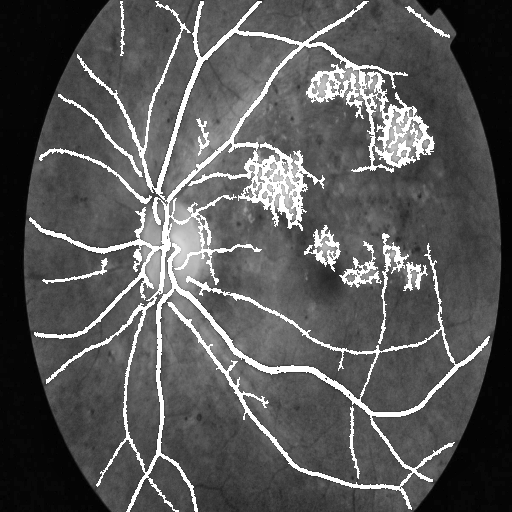

In [ ]:
from google.colab.patches import cv2_imshow
# d = np.concatenate((a,b,c),axis=1)
cv2_imshow(a)

In [ ]:
data_dir = pathlib.Path('/content/drive/MyDrive/IMG_EXU_SET').with_suffix('')
data_dir2 = pathlib.Path('/content/drive/MyDrive/IMG_EXU_SET/AbNR').with_suffix('')


NR = data_dir.glob('NR/*.*')
ABNOR = data_dir.glob('ABNOR/*.*')

EX = data_dir2.glob('EX/*.*')
NO_EX =data_dir2.glob('NO_EX/*.*')


data = []
labels = []

data_ex = []
labels_ex = []



for i in NR:

    im1 = PROCESSING(str(i))
    data.append(im1)
    labels.append(0)

for i in ABNOR:

    im1 = PROCESSING(str(i))
    data.append(im1)
    labels.append(1)


data = np.array(data)
labels = np.array(labels)



for i in NO_EX:

    im1 = PROCESSING(str(i))
    data_ex.append(im1)
    labels_ex.append(0)


for i in EX:

    im1 = PROCESSING(str(i))
    data_ex.append(im1)
    labels_ex.append(1)


data_ex = np.array(data_ex)
labels_ex = np.array(labels_ex)




In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, ytrain, ytest = train_test_split(data, encode(labels), test_size=0.15,
                                                random_state=42)


X_train_ex, X_test_ex, ytrain_ex, ytest_ex = train_test_split(data_ex, encode(labels_ex), test_size=0.15,
                                                random_state=32)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
data_dir = pathlib.Path('/content/drive/MyDrive/IMG_EXU_SET/').with_suffix('')

NR = data_dir.glob('NR/*.*')
EX = data_dir.glob('AbNR/EX*.*')
NO_EX = data_dir.glob('AbNR/NO_EX*.*')

data_ = []
labels_ = []
labels_ex_ = []

n=1

for i in NR:

    im = PROCESSING(str(i))
    data_.append(im)
    labels_.append(0)
    labels_ex_.append(0)


for i in EX:

    im = PROCESSING(str(i))
    data_.append(im)
    labels_.append(1)
    labels_ex_.append(1)


for i in NO_EX:

    im = PROCESSING(str(i))
    data_.append(im)
    labels_.append(1)
    labels_ex_.append(0)


# data_ = np.array(data_)
# labels_ = np.array(labels_)
# labels_ex_ = np.array(labels_ex_)




In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, ytrain, ytest = train_test_split(data_, encode(labels_), test_size=0.15,
                                                random_state=42)


X_train_ex, X_test_ex, ytrain_ex, ytest_ex = train_test_split(data_, encode(labels_ex_), test_size=0.15,
                                                random_state=32)


In [ ]:

# Build model.
width = data_ex[0][0].shape[0]
height = data_ex[0][1].shape[0]

with strategy.scope():
# with tf.device('/GPU:0'):
    model2 = get_model(width, height)

model2.summary()

Model: "BASE_MODEL"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 508, 508, 16  416         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 508, 508, 16  64         ['conv2d_4[0][0]']               
 rmalization)                   )                                                        

In [ ]:
  from google.colab.patches import cv2_imshow
cv2_imshow(X_train_ex[20])


In [ ]:
model2.load_weights('/content/Process_model2.h5')

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)

with strategy.scope():



# with tf.device('/GPU:0'):

  model2.compile(
      loss="binary_crossentropy",
      optimizer=tf.keras.optimizers.Adam(lr_schedule),
      metrics=['acc',tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall()],
  )

# Define callbacks.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "image_classification-2.h5", save_best_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="acc", patience=4)


epochs = 12

model2.fit(
    x=X_train_ex,
    y=ytrain_ex,
    validation_split=0.1,
    validation_freq=5,
    epochs=epochs,
    shuffle=True,
    batch_size=32,

#     callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/12
4/4 [==============================] - 7s 272ms/step - loss: 0.3538 - acc: 0.9298 - precision_28: 0.9298 - recall_28: 0.9298
Epoch 2/12
4/4 [==============================] - 1s 274ms/step - loss: 0.0787 - acc: 0.9825 - precision_28: 0.9825 - recall_28: 0.9825
Epoch 3/12
4/4 [==============================] - 1s 275ms/step - loss: 0.0066 - acc: 1.0000 - precision_28: 1.0000 - recall_28: 1.0000
Epoch 4/12
4/4 [==============================] - 1s 272ms/step - loss: 0.0239 - acc: 1.0000 - precision_28: 1.0000 - recall_28: 1.0000
Epoch 5/12
4/4 [==============================] - 2s 504ms/step - loss: 0.0016 - acc: 1.0000 - precision_28: 1.0000 - recall_28: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000 - val_precision_28: 1.0000 - val_recall_28: 1.0000
Epoch 6/12
4/4 [==============================] - 1s 279ms/step - loss: 2.7787e-04 - acc: 1.0000 - precision_28: 1.0000 - recall_28: 1.0000
Epoch 7/12
4/4 [==============================] - 1s 283ms/step - loss: 6.6623e-04 - acc: 1.

In [ ]:
# model2.load_weights('Process_model2.h5')
pred = model2.predict(X_test_ex).round()
print('Model Classification report \n\n {}'.format(metrics.classification_report(ytest_ex,pred)))
print('Model accuracy  {} %'.format(metrics.accuracy_score(ytest_ex,pred)*100))


1/1 [==============================] - 0s 226ms/step
Model Classification report 

               precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       0.87      0.93      0.90        14

   micro avg       0.87      0.87      0.87        23
   macro avg       0.87      0.85      0.86        23
weighted avg       0.87      0.87      0.87        23
 samples avg       0.87      0.87      0.87        23

Model accuracy  86.95652173913044 %


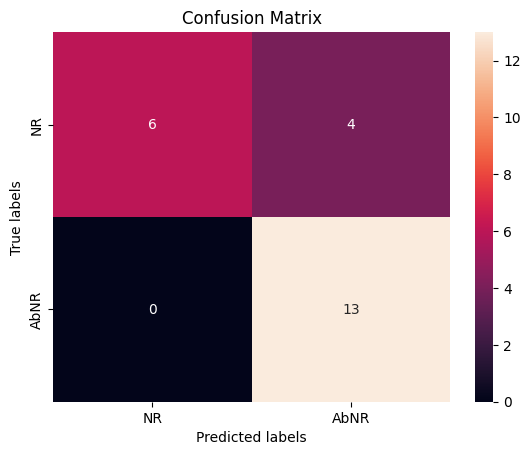

In [ ]:
import seaborn as sns
class_names = ['NR','AbNR']
ax= plt.subplot()
cm = metrics.confusion_matrix(ytest_ex.argmax(axis=1), pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);


In [ ]:
model2.save('Process_model2.h5')

In [ ]:

# Build model.
width = data[0][0].shape[0]
height = data[0][1].shape[0]

with strategy.scope():
# with tf.device('/GPU:0'):
    model1 = get_model(width, height)

model1.summary()

Model: "BASE_MODEL"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 508, 508, 16  416         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 508, 508, 16  64         ['conv2d_8[0][0]']               
 rmalization)                   )                                                        

In [ ]:
# model1.load_weights('No_Process_model1.h5')

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)

with strategy.scope():



# with tf.device('/GPU:0'):

  model1.compile(
      loss="binary_crossentropy",
      optimizer=tf.keras.optimizers.Adam(lr_schedule),
      metrics=['acc',tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall()],
  )

# Define callbacks.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "image_classification-2.h5", save_best_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="acc", patience=4)


epochs = 15

model1.fit(
    x=X_train,
    y=ytrain,
    validation_split=0.1,
    validation_freq=5,
    epochs=epochs,
    shuffle=True,
    batch_size=32,

#     callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/15
5/5 [==============================] - 5s 269ms/step - loss: 0.0110 - acc: 1.0000 - precision_35: 1.0000 - recall_35: 1.0000
Epoch 2/15
5/5 [==============================] - 1s 262ms/step - loss: 0.0288 - acc: 1.0000 - precision_35: 1.0000 - recall_35: 1.0000
Epoch 3/15
5/5 [==============================] - 1s 267ms/step - loss: 0.0282 - acc: 1.0000 - precision_35: 1.0000 - recall_35: 1.0000
Epoch 4/15
5/5 [==============================] - 1s 267ms/step - loss: 0.0133 - acc: 1.0000 - precision_35: 1.0000 - recall_35: 1.0000
Epoch 5/15
5/5 [==============================] - 2s 398ms/step - loss: 4.1706e-04 - acc: 1.0000 - precision_35: 1.0000 - recall_35: 1.0000 - val_loss: 0.7235 - val_acc: 0.8125 - val_precision_35: 0.8125 - val_recall_35: 0.8125
Epoch 6/15
5/5 [==============================] - 1s 267ms/step - loss: 0.0071 - acc: 1.0000 - precision_35: 1.0000 - recall_35: 1.0000
Epoch 7/15
5/5 [==============================] - 1s 265ms/step - loss: 2.1670e-04 - acc: 1.

In [ ]:
# model2.load_weights('Process_model1.h5')
pred = model1.predict(X_test).round()
print('Model Classification report \n\n {}'.format(metrics.classification_report(ytest,pred)))
print('Model accuracy  {} %'.format(metrics.accuracy_score(ytest,pred)*100))


1/1 [==============================] - 0s 72ms/step
Model Classification report 

               precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.93      0.93      0.93        14

   micro avg       0.93      0.93      0.93        28
   macro avg       0.93      0.93      0.93        28
weighted avg       0.93      0.93      0.93        28
 samples avg       0.93      0.93      0.93        28

Model accuracy  92.85714285714286 %


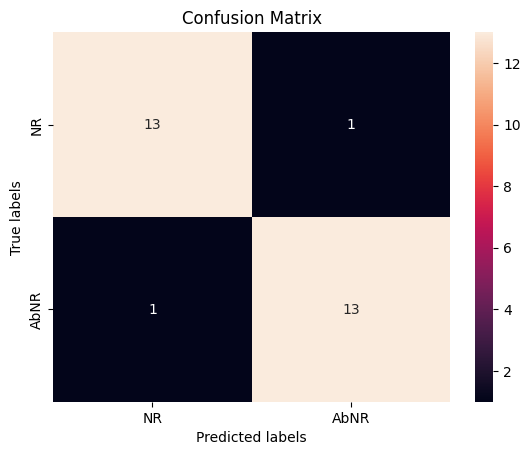

In [ ]:
import seaborn as sns
class_names = ['NR','AbNR']
ax= plt.subplot()
cm = metrics.confusion_matrix(ytest.argmax(axis=1), pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);


In [ ]:
model1.save_weights('Process_model1.h5')

In [ ]:
model1 = get_model(512, 512)
model1.load_weights('Process_model1.h5')

model2 = get_model(512, 512)
model2.load_weights('Process_model2.h5')


In [ ]:
data_dir = pathlib.Path('IMG_EXU_SET').with_suffix('')
# data_dir2 = pathlib.Path('IMG_EXU_SET/AbNR').with_suffix('')


NR = data_dir.glob('NR/*.*')
# ABNOR = data_dir.glob('ABNOR/*.*')

EX = data_dir.glob('AbNR/EX/*.*')
NO_EX =data_dir.glob('AbNR/NO_EX/*.*')

# data_ex_2 = []
data_2 = []
labels_2 = []
labels_ex_2 = []



for i in NR:

    im = PROCESSING(str(i))
    data_2.append(im)
    labels_2.append(0)
    labels_ex_2.append(0)


for i in EX:

    im = PROCESSING(str(i))
    data_2.append(im)
    labels_2.append(1) #For abnormal
    labels_ex_2.append(1) #For abnormal with Exudate

for i in NO_EX:

    im = PROCESSING(str(i))
    data_2.append(im)
    labels_2.append(1)
    labels_ex_2.append(0)


# data_ex = np.array(data_ex)
labels_ex_2 = encode(np.array(labels_ex_2))
data_2 = np.array(data_2)
labels_2 = encode(np.array(labels_2))




In [ ]:
model1 = get_model(512, 512)
model1.load_weights('Process_model1.h5')

model2 = get_model(512, 512)
model2.load_weights('Process_model2.h5')


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, ytrain, ytest = train_test_split(data_2, labels_2, test_size=0.15,
                                                random_state=38)


# X_train_ex, X_test_ex, ytrain_ex, ytest_ex = train_test_split(data_, encode(labels_ex_), test_size=0.15,
#                                                 random_state=32)


In [ ]:
data_2.shape[0]

228

In [ ]:
pred1 = model1.predict(X_test[35].reshape(1,512,512)).round()


metrics.accuracy_score(ytest[35].reshape(1,2),pred1)

1/1 [==============================] - 0s 98ms/step


1.0

In [ ]:
Normal = [[1.,0.]]
NotNormal = [[0.,1.]]
Exudate = [[0.,1.]]
NoExudate = [[1.,0.]]

acc1 = []
acc2 = []
accu =[]

for i in range(X_test.shape[0]):

    pred1 = model1.predict(X_test[i].reshape(1,512,512)).round()
    acc1.append(metrics.accuracy_score(ytest[i].reshape(1,2),pred1))

    if (pred1 == Normal).all():
        accu.append(metrics.accuracy_score(ytest[i].reshape(1,2),pred1) )


    if (pred1 != Normal).all():
        pred2 = model2.predict(X_test[i].reshape(1,512,512)).round()
        acc2.append(metrics.accuracy_score(ytest[i].reshape(1,2),pred2))

        accu.append(metrics.accuracy_score(ytest[i].reshape(1,2),pred2))





1/1 [==============================] - 0s 79ms/step


In [ ]:
from statistics import mean
print('Model1 acc: ',mean(acc1))
print('Model2 acc: ',mean(acc2))
m = (mean(acc2) + mean(acc1))/2
print('Overall Model acc: ',m)

In [ ]:
print('Model acc: ',mean(accu))

In [ ]:
data_dir = pathlib.Path('/content/drive/MyDrive/SUSTECH/').with_suffix('')
# data_dir2 = pathlib.Path('IMG_EXU_SET/AbNR').with_suffix('')


NR = data_dir.glob('Normal/*.*')
# ABNOR = data_dir.glob('ABNOR/*.*')

EX = data_dir.glob('Exudates/*.*')
# NO_EX =data_dir.glob('AbNR/NO_EX/*.*')

# data_ex_2 = []
data_3 = []
labels_3 = []
labels_ex_3 = []



for i in NR:

    im = PROCESSING(str(i))
    data_3.append(im)
    labels_3.append(0)
    labels_ex_3.append(0)


for i in EX:

    im = PROCESSING(str(i))
    data_3.append(im)
    labels_3.append(1) #For abnormal
    labels_ex_3.append(1) #For abnormal with Exudate

# for i in NO_EX:

#     im = PROCESSING(str(i))
#     data_2.append(im)
#     labels_2.append(1)
#     labels_ex_2.append(0)


# data_ex = np.array(data_ex)
labels_ex_3 = encode(np.array(labels_ex_3))
data_3 = np.array(data_3)
labels_3 = encode(np.array(labels_3))




/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:


# Build model.
width = 512
height = 512

model1 = get_model(width, height)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, ytrain, ytest = train_test_split(data_3, labels_3, test_size=0.15,
                                                random_state=38)


In [ ]:
model1.load_weights('Process_model1.h5')
pred = model1.predict(X_test).round()
print('Model Classification report \n\n {}'.format(metrics.classification_report(ytest,pred)))
print('Model accuracy  {} %'.format(metrics.accuracy_score(ytest,pred)*100))


3/3 [==============================] - 0s 85ms/step
Model Classification report 

               precision    recall  f1-score   support

           0       0.82      0.96      0.88        47
           1       0.95      0.78      0.86        46

   micro avg       0.87      0.87      0.87        93
   macro avg       0.88      0.87      0.87        93
weighted avg       0.88      0.87      0.87        93
 samples avg       0.87      0.87      0.87        93

Model accuracy  87.09677419354838 %
